In [1]:
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
from config import configcovid

In [2]:
# Download the data from https://covid.ourworldindata.org/ size around 80 MB
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

# Save to local drive in data folder
df.to_csv('data/covid_data.csv')

# Read from local drive
# df = pd.read_csv('data/covid_data.csv')

In [3]:
# Define column for each table
str_col = configcovid.str_col
date_col = configcovid.date_col
float_col = configcovid.float_col
dimention_col = configcovid.dimention_col
covid_col = configcovid.covid_col
vaccinated_col = configcovid.vaccinated_col
excess_col = configcovid.excess_col

# Change column data type
df[str_col] = df[str_col].astype('string')
df[float_col] = df[float_col].astype('float')
for col in date_col:
    df[col] = pd.to_datetime(df[col])

In [4]:
# Split data into different dataframe 
df_dimention = df[list(configcovid.dimention_col.keys())].drop_duplicates().reset_index(drop=True)
df_covid = df[list(configcovid.covid_col.keys())]
df_vaccinated = df[list(configcovid.vaccinated_col.keys())]
df_excess = df[list(configcovid.excess_col.keys())].query("not(excess_mortality_cumulative_absolute.isnull())").reset_index(drop=True)

In [5]:
def sql_insert(data=pd.DataFrame,name=str,engine=sqlalchemy.engine,schema =str,col_type=dict)->None:
    print(f'Inserting data for {name}')
    try:
        data.to_sql(con=engine,schema=schema,name=name,index=False,if_exists='replace',dtype=col_type)
    except Exception as err:
        print(f'An error occur {err} table.')

    print(f'Finish inserting data')
    print('-----------------------')
    return None

def sql_excute(query=str,engine=sqlalchemy.engine)->None:
    print('Executing query command...')
    engine.execute(statement=query)
    print('Finish Executing')
    print('-----------------------')
    return None

def sql_excute_command(query=str,session=sqlalchemy.engine.cursor)->None:
    print('Executing command...')
    session.execute(query)
    session.commit()
    print('Finish Executing')
    print('-----------------------')
    return None

In [6]:
# Connect to local MS SQL Server with fast excute on
eng = sqlalchemy.create_engine("mssql://localhost/Covid_Database?driver=ODBC Driver 17 for SQL Server",fast_executemany=True)
schema = 'stg'
schema_query = f"""
IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = '{schema}')
BEGIN
EXEC('CREATE SCHEMA {schema}')
END"""

# Create stg schema if not exist
sql_excute(schema_query,eng)

Executing query command...
Finish Executing
-----------------------


In [7]:


# Write data into sql server
df_insert = [
    (df_dimention,'stg_dimention',dimention_col),
    (df_covid,'stg_covid',covid_col),
    (df_vaccinated,'stg_vaccinated',vaccinated_col),
    (df_excess,'stg_excess',excess_col)
    ]
for df,name,col_type in df_insert:
    sql_insert(data=df,name=name,engine=eng,schema=schema,col_type=col_type)

# Create insert store procedure
for sp in configcovid.sp_list:
    sql_excute(query=sp,engine=eng)

# Excute the store procedure to insert the data if first time will create table if not will insert date more than the current data
session = eng.raw_connection().cursor()
for sp in configcovid.sp_excute_list:
    query = f'exec [dbo].[{sp}]'
    print(sp)
    sql_excute_command(query=query,session=session)

# Create view for further analysis
for vw in configcovid.view_list:
    sql_excute_command(query=vw,session=session)


session.close()


Inserting data for stg_dimention
Finish inserting data
-----------------------
Inserting data for stg_covid
Finish inserting data
-----------------------
Inserting data for stg_vaccinated
Finish inserting data
-----------------------
Inserting data for stg_excess
Finish inserting data
-----------------------
Executing query command...
Finish Executing
-----------------------
Executing query command...
Finish Executing
-----------------------
Executing query command...
Finish Executing
-----------------------
Executing query command...
Finish Executing
-----------------------
Stg_Covid_insert
Executing command...
Finish Executing
-----------------------
Stg_Vaccinated_insert
Executing command...
Finish Executing
-----------------------
Stg_Dimention_insert
Executing command...
Finish Executing
-----------------------
Stg_Excess_insert
Executing command...
Finish Executing
-----------------------
Executing command...
Finish Executing
-----------------------
Executing command...
Finish Ex

In [8]:
country = 'USA'
df_query = pd.read_sql(sql=configcovid.query_Newdata_avg,con=eng).query("iso_code ==@country").reset_index(drop=True)
df_query[configcovid.typelist] = df_query[configcovid.typelist].astype('float')

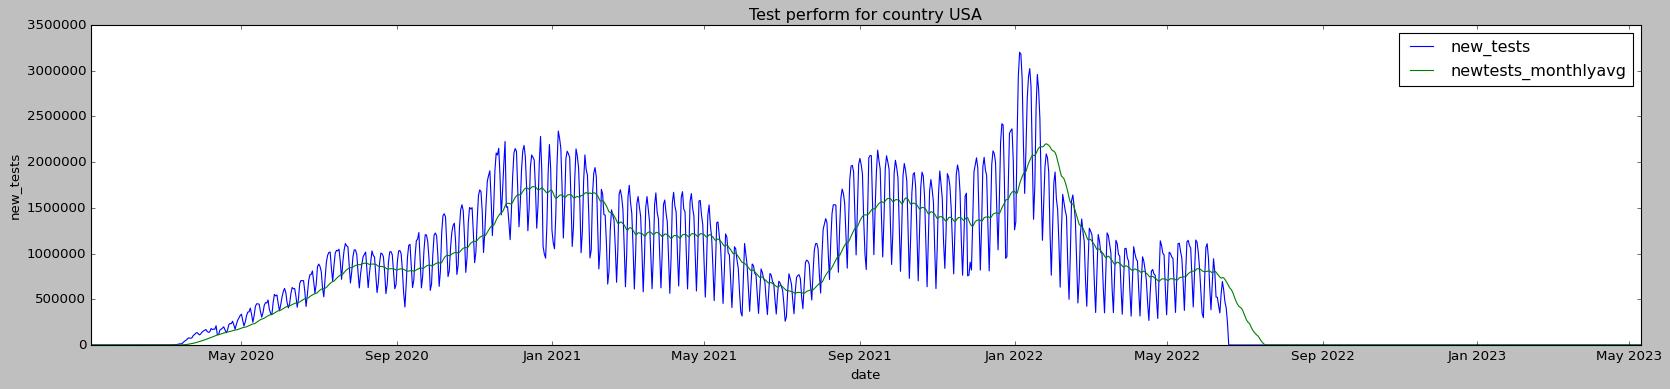

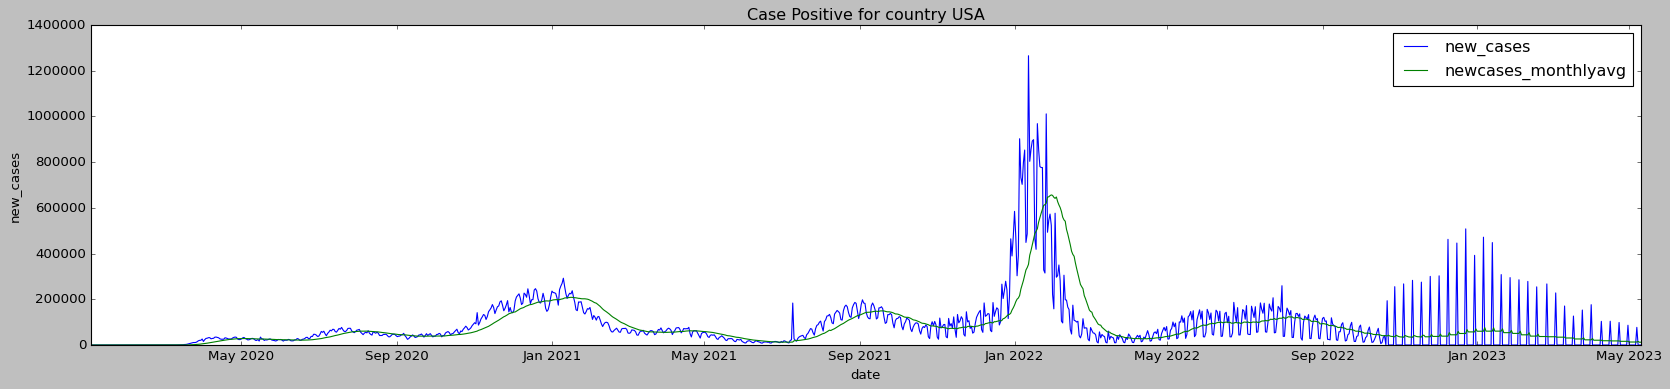

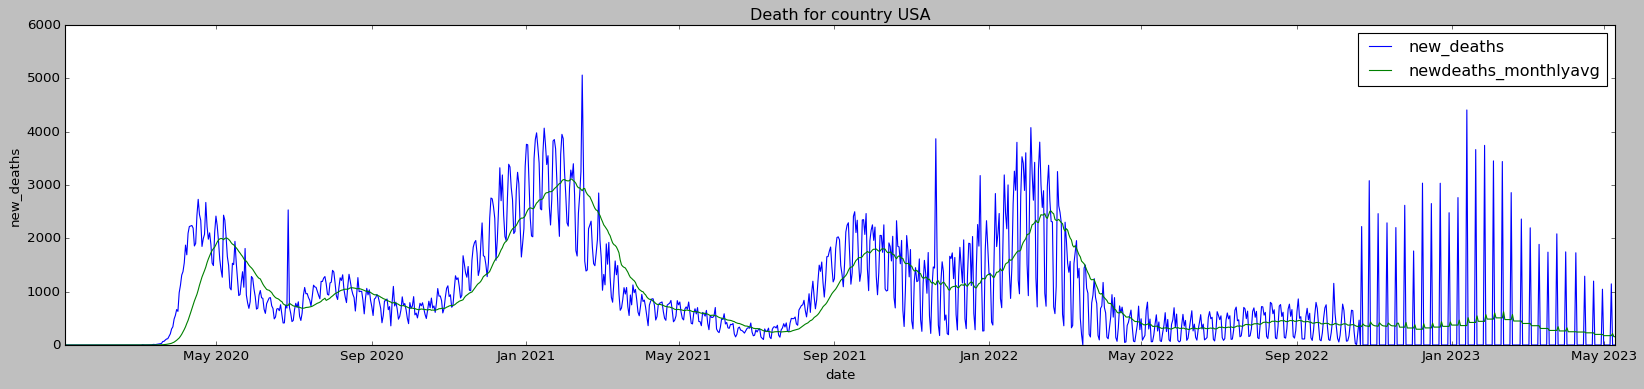

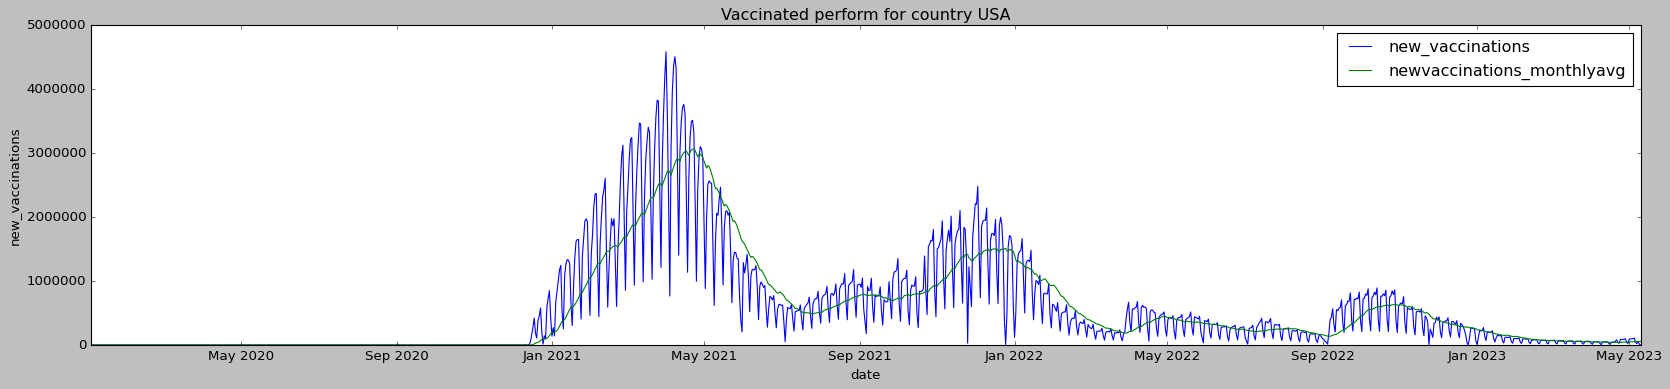

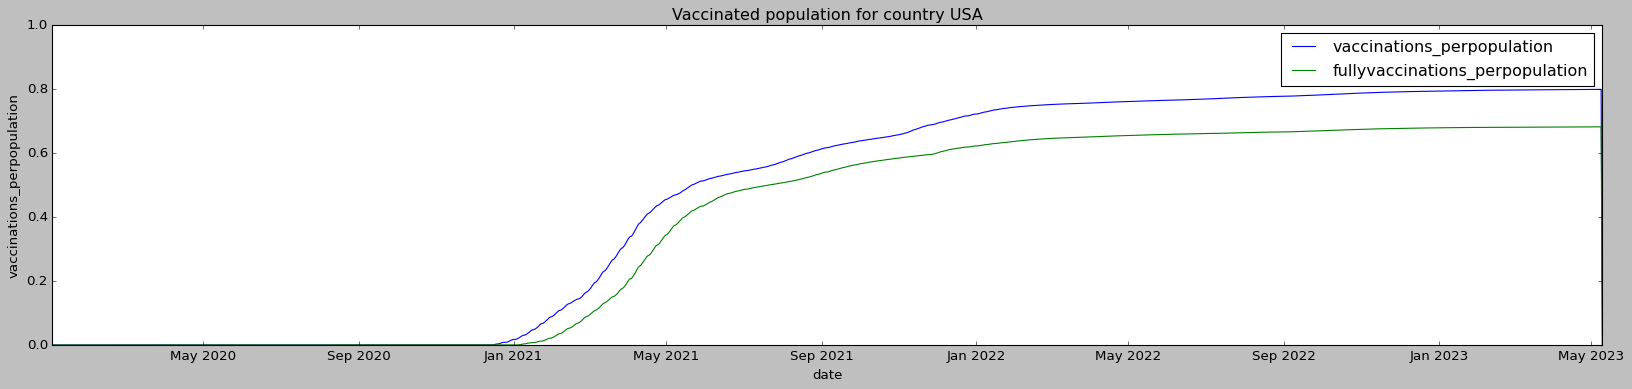

In [9]:
plt.style.use('classic')
plt.figure(figsize=(25,5))

plt.title(f'Test perform for country {country}')
sns.lineplot(data=df_query,x='date',y=configcovid.test_list[0])
sns.lineplot(data=df_query,x='date',y=configcovid.test_list[1])
plt.legend(configcovid.test_list)
plt.show()

plt.style.use('classic')
plt.figure(figsize=(25,5))
plt.title(f'Case Positive for country {country}')
sns.lineplot(data=df_query,x='date',y=configcovid.cases_list[0])
sns.lineplot(data=df_query,x='date',y=configcovid.cases_list[1])
plt.legend(configcovid.cases_list)
plt.show()

plt.style.use('classic')
plt.figure(figsize=(25,5))
plt.title(f'Death for country {country}')
sns.lineplot(data=df_query,x='date',y=configcovid.deaths_list[0])
sns.lineplot(data=df_query,x='date',y=configcovid.deaths_list[1])
plt.legend(configcovid.deaths_list)
plt.show()

plt.style.use('classic')
plt.figure(figsize=(25,5))
plt.title(f'Vaccinated perform for country {country}')
sns.lineplot(data=df_query,x='date',y=configcovid.vaccinated_list[0])
sns.lineplot(data=df_query,x='date',y=configcovid.vaccinated_list[1])
plt.legend(configcovid.vaccinated_list)
plt.show()

plt.style.use('classic')
plt.figure(figsize=(25,5))
plt.title(f'Vaccinated population for country {country}')
sns.lineplot(data=df_query,x='date',y=configcovid.vaccinatedtotal_list[0])
sns.lineplot(data=df_query,x='date',y=configcovid.vaccinatedtotal_list[1])
plt.legend(configcovid.vaccinatedtotal_list)
plt.ylim(0,1)
plt.show()

In [10]:
# What is the top 10 country that have the most covid case per population?
df_query = pd.read_sql(sql=configcovid.query_Top10_infected,con=eng)
df_query

,iso_code,location,continent,population,total_cases,infected_population,vaccinations_population
0,AUT,Austria,Europe,8939617,6069252,67.89%,77.18%
1,SVN,Slovenia,Europe,2119843,1343721,63.39%,59.71%
2,KOR,South Korea,Asia,51815808,31285910,60.38%,86.44%
3,GRC,Greece,Europe,10384972,6025776,58.02%,76.41%
4,DNK,Denmark,Europe,5882259,3412445,58.01%,81.2%
5,FRA,France,Europe,67813000,38961098,57.45%,80.62%
6,PRT,Portugal,Europe,10270857,5582987,54.36%,95.26%
7,LVA,Latvia,Europe,1850654,977774,52.83%,72.74%
8,ISR,Israel,Asia,9449000,4823329,51.05%,71.15%
9,CHE,Switzerland,Europe,8740471,4403468,50.38%,69.75%


In [11]:
# What is the top 10 country that have the most death case per population?
df_query = pd.read_sql(sql=configcovid.query_Top10_death,con=eng)
df_query

,iso_code,location,continent,population,total_cases,death_population,infected_population
0,PER,Peru,South America,34049588,4503222,0.65%,13.23%
1,BGR,Bulgaria,Europe,6781955,1305298,0.57%,19.25%
2,BIH,Bosnia and Herzegovina,Europe,3233530,402890,0.51%,12.46%
3,HUN,Hungary,Europe,9967304,2201824,0.49%,22.09%
4,MKD,North Macedonia,Europe,2093606,348215,0.46%,16.63%
5,GEO,Georgia,Asia,3744385,1840187,0.46%,49.15%
6,HRV,Croatia,Europe,4030361,1273256,0.45%,31.59%
7,SVN,Slovenia,Europe,2119843,1343721,0.44%,63.39%
8,CZE,Czechia,Europe,10493990,4640905,0.41%,44.22%
9,SVK,Slovakia,Europe,5643455,1866647,0.38%,33.08%


In [12]:
# What is the overview of top 10 country with highest GDP?
df_query = pd.read_sql(sql=configcovid.query_Top10_gdp,con=eng)
df_query

,iso_code,location,continent,population,gdp_per_capita,total_cases,infected_population,vaccinations_population,death_population
0,QAT,Qatar,Asia,2695131,116935.600,509440,18.9%,105.83%,0.03%
1,SGP,Singapore,Asia,5637022,85535.383,2391248,42.42%,91.55%,0.03%
2,IRL,Ireland,Europe,5023108,67335.293,1710625,34.06%,81.79%,0.18%
3,ARE,United Arab Emirates,Asia,9441138,67293.483,1064237,11.27%,105.83%,0.02%
4,KWT,Kuwait,Asia,4268886,65530.537,665851,15.6%,80.98%,0.06%
5,NOR,Norway,Europe,5434324,64800.057,1483639,27.3%,79.99%,0.1%
6,CHE,Switzerland,Europe,8740471,57410.166,4403468,50.38%,69.75%,0.16%
7,USA,United States,North America,338289856,54225.446,103343569,30.55%,79.88%,0.33%
8,SAU,Saudi Arabia,Asia,36408824,49045.411,841469,2.31%,74.27%,0.03%
9,NLD,Netherlands,Europe,17564020,48472.545,8610372,49.02%,72.74%,0.13%


In [15]:
# What is the overview of top 10 country with highest life expectancy?
df_query = pd.read_sql(sql=configcovid.query_Top10_gdp,con=eng)
df_query

,iso_code,location,continent,population,gdp_per_capita,total_cases,infected_population,vaccinations_population,death_population
0,QAT,Qatar,Asia,2695131,116935.600,509440,18.9%,105.83%,0.03%
1,SGP,Singapore,Asia,5637022,85535.383,2391248,42.42%,91.55%,0.03%
2,IRL,Ireland,Europe,5023108,67335.293,1710625,34.06%,81.79%,0.18%
3,ARE,United Arab Emirates,Asia,9441138,67293.483,1064237,11.27%,105.83%,0.02%
4,KWT,Kuwait,Asia,4268886,65530.537,665851,15.6%,80.98%,0.06%
5,NOR,Norway,Europe,5434324,64800.057,1483639,27.3%,79.99%,0.1%
6,CHE,Switzerland,Europe,8740471,57410.166,4403468,50.38%,69.75%,0.16%
7,USA,United States,North America,338289856,54225.446,103343569,30.55%,79.88%,0.33%
8,SAU,Saudi Arabia,Asia,36408824,49045.411,841469,2.31%,74.27%,0.03%
9,NLD,Netherlands,Europe,17564020,48472.545,8610372,49.02%,72.74%,0.13%


In [13]:
# What is the current overview of covid for each continent
df_query = pd.read_sql(sql=configcovid.query_Continent_Overview,con=eng)
df_query

,iso_code,location,continent,population,percent_oftotal,total_cases,death_population,infected_population,vaccinations_population,fullyvaccinations_population
0,OWID_WRL,World,Continent,7975105024,48.63%,765902514,0.09%,9.6%,69.99%,64.36%
1,OWID_ASI,Asia,Continent,4721383370,28.79%,296996200,0.03%,6.29%,77.75%,72.83%
2,OWID_AFR,Africa,Continent,1426736614,8.7%,13084565,0.02%,0.92%,36.79%,30.55%
3,OWID_EUR,Europe,Continent,744807803,4.54%,249194610,0.28%,33.46%,70.23%,67.05%
4,OWID_NAM,North America,Continent,600323657,3.66%,124060243,0.27%,20.67%,76.33%,65.68%
5,OWID_EUN,European Union,Continent,450146793,2.74%,183976990,0.27%,40.87%,75.13%,72.9%
6,OWID_SAM,South America,Continent,436816679,2.66%,68527443,0.31%,15.69%,85.93%,77.11%
7,OWID_OCE,Oceania,Continent,45038860,0.27%,14033967,0.06%,31.16%,64.31%,62.1%


In [14]:
# What is the current overview of covid for each income class
df_query = pd.read_sql(sql=configcovid.query_Class_Overview,con=eng)
df_query

,iso_code,location,continent,population,percent_oftotal,total_cases,death_population,infected_population,vaccinations_population,fullyvaccinations_population
0,OWID_LMC,Lower middle income,Class,3432097300,43.19%,97476899,0.04%,2.84%,65.7%,58.89%
1,OWID_UMC,Upper middle income,Class,2525921300,31.79%,243707581,0.11%,9.65%,83.42%,78.74%
2,OWID_HIC,High income,Class,1250514600,15.74%,421208117,0.23%,33.68%,79.87%,74.8%
3,OWID_LIC,Low income,Class,737604900,9.28%,2299515,0.01%,0.31%,29.89%,25.4%
